In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import itertools  
from scipy import stats



In [2]:
# Setting date for bt period 
start_date = '2022-11-19'
end_date = '2024-11-19'
window_size = 30  # Roll size 

In [3]:
def get_stock_data(tickers, start_date, end_date):
    """Get stock data for given tickers"""
    data = pd.DataFrame()
    for ticker in tickers:
        try:
            stock = yf.download(ticker, start=start_date, end=end_date)['Adj Close']
            data[ticker] = stock
        except Exception as e:
            print(f"Error downloading {ticker}: {e}")
    return data

In [4]:
def calculate_portfolio_metrics(returns):
    """Calculate portfolio performance metrics"""
    if len(returns) == 0 or returns.isnull().all():
        return {
            'Annual Return': np.nan,
            'Annual Volatility': np.nan,
            'Sharpe Ratio': np.nan,
            'Max Drawdown': np.nan
        }
    
    # Annualized return
    ann_return = (1 + returns.mean()) ** 252 - 1
    
    # Annualized volatility
    ann_vol = returns.std() * np.sqrt(252)
    
    # Sharpe ratio (assuming risk-free rate = 0.02)
    rf = 0.02
    sharpe = (ann_return - rf) / ann_vol if ann_vol != 0 else np.nan
    
    # Maximum drawdown
    cum_returns = (1 + returns).cumprod()
    running_max = cum_returns.cummax()
    drawdowns = (cum_returns - running_max) / running_max
    mdd = drawdowns.min()
    
    return {
        'Annual Return': ann_return,
        'Annual Volatility': ann_vol,
        'Sharpe Ratio': sharpe,
        'Max Drawdown': mdd
    }


In [5]:
def calculate_enhanced_metrics(returns):
    """Calculate additional portfolio performance metrics with fixed calculations"""
    
    # Convert returns to numpy array for statistical calculations
    returns_array = returns.dropna().values
    
    if len(returns_array) == 0:
        return {k: np.nan for k in ['Annual Return', 'Annual Volatility', 'Sortino Ratio',
                                   'Calmar Ratio', 'VaR (95%)', 'VaR (99%)', 'CVaR (95%)',
                                   'CVaR (99%)', 'Skewness', 'Kurtosis', 'Information Ratio',
                                   'Win Rate', 'Profit Ratio', 'Max Consecutive Wins',
                                   'Max Consecutive Losses', 'Average Rolling Beta']}
    
    # Basic metrics
    mean_return = returns.mean()
    std_dev = returns.std()
    ann_return = (1 + mean_return) ** 252 - 1
    ann_vol = std_dev * np.sqrt(252)
    
    # 1. Sortino Ratio
    rf = 0.02
    downside_returns = returns[returns < 0]
    downside_std = downside_returns.std() * np.sqrt(252)
    sortino_ratio = (ann_return - rf) / downside_std if downside_std != 0 else np.nan
    
    # 2. Calmar Ratio
    cum_returns = (1 + returns).cumprod()
    running_max = cum_returns.cummax()
    drawdowns = (cum_returns - running_max) / running_max
    max_drawdown = drawdowns.min()
    calmar_ratio = ann_return / abs(max_drawdown) if max_drawdown != 0 else np.nan
    
    # 3. VaR - Fix: Calculate directly from returns distribution
    var_95 = np.percentile(returns_array, 5)
    var_99 = np.percentile(returns_array, 1)
    
    # 4. CVaR - Fix: Calculate mean of returns below VaR
    cvar_95 = returns[returns <= var_95].mean()
    cvar_99 = returns[returns <= var_99].mean()
    
    # 5. Skewness and Kurtosis - Fix: Use returns array directly
    skewness = stats.skew(returns_array)
    kurtosis = stats.kurtosis(returns_array)
    
    # 6. Information Ratio
    try:  
        benchmark = yf.download('SPY', start=returns.index[0], end=returns.index[-1])['Adj Close']
        # using SPY S&P 500 as the default benchmark 
        benchmark_returns = benchmark.pct_change()
        excess_returns = returns - benchmark_returns
        information_ratio = (excess_returns.mean() * 252) / (excess_returns.std() * np.sqrt(252))
    except:
        information_ratio = np.nan
    
    # 7. Win Rate and Profit Ratio
    winning_days = (returns > 0).sum()
    losing_days = (returns < 0).sum()
    win_rate = winning_days / (winning_days + losing_days)
    
    avg_win = returns[returns > 0].mean()
    avg_loss = abs(returns[returns < 0].mean())
    profit_ratio = avg_win / avg_loss if avg_loss != 0 else np.nan
    
    # 8. Maximum Consecutive Wins/Losses
    pos_streaks = (returns > 0).astype(int)
    neg_streaks = (returns < 0).astype(int)
    
    max_consecutive_wins = max(sum(1 for _ in group) 
                             for key, group in itertools.groupby(pos_streaks) if key == 1)
    max_consecutive_losses = max(sum(1 for _ in group) 
                               for key, group in itertools.groupby(neg_streaks) if key == 1)
    
    # 9. Rolling Beta calculation remains the same
    rolling_beta = pd.Series(index=returns.index)
    window = min(30, len(returns))  
    for i in range(window, len(returns)):
        window_returns = returns.iloc[i-window:i]
        window_benchmark = benchmark_returns.iloc[i-window:i]
        try:
            coef = np.cov(window_returns, window_benchmark)[0,1] / np.var(window_benchmark)
            rolling_beta.iloc[i] = coef
        except:
            rolling_beta.iloc[i] = np.nan
    
    return {
        'Annual Return': ann_return,
        'Annual Volatility': ann_vol,
        'Sortino Ratio': sortino_ratio,
        'Calmar Ratio': calmar_ratio,
        'VaR (95%)': var_95,
        'VaR (99%)': var_99,
        'CVaR (95%)': cvar_95,
        'CVaR (99%)': cvar_99,
        'Skewness': skewness,
        'Kurtosis': kurtosis,
        'Information Ratio': information_ratio,
        'Win Rate': win_rate,
        'Profit Ratio': profit_ratio,
        'Max Consecutive Wins': max_consecutive_wins,
        'Max Consecutive Losses': max_consecutive_losses,
        'Average Rolling Beta': rolling_beta.mean()
    }
    
######################################################################################


def plot_enhanced_metrics(rolling_metrics_dict):
    """Plot additional rolling metrics with proper error handling and label checking"""
    metrics_to_plot = [
        ('Rolling Beta', 'Beta relative to market'),
        ('Sortino Ratio', 'Risk-adjusted return (downside risk)'),
        ('VaR (95%)', 'Value at Risk'),
        ('Win Rate', 'Proportion of winning days')
    ]
    
    fig, axes = plt.subplots(len(metrics_to_plot), 1, figsize=(15, 20))
    fig.suptitle('Enhanced Rolling Window Metrics')
    
    for i, (metric, subtitle) in enumerate(metrics_to_plot):
        has_data = False  # Flag to check if any data was plotted
        
        for portfolio_name, portfolio_data in rolling_metrics_dict.items():
            # Convert to DataFrame if it's a Series
            if isinstance(portfolio_data, pd.Series):
                portfolio_data = portfolio_data.to_frame()
                
            # Check if the metric exists in the portfolio data
            if metric in portfolio_data.columns:
                data = portfolio_data[metric].dropna()  # Remove NaN values
                if not data.empty:
                    axes[i].plot(
                        data.index,
                        data.values,
                        label=portfolio_name
                    )
                    has_data = True
        
        axes[i].set_title(f'{metric}\n{subtitle}')
        if has_data:  # Only add legend if data was plotted
            axes[i].legend()
        axes[i].grid(True)
        
        # Add a note if no data was plotted
        if not has_data:
            axes[i].text(0.5, 0.5, f'No data available for {metric}',
                        horizontalalignment='center',
                        verticalalignment='center',
                        transform=axes[i].transAxes)
    
    plt.tight_layout()
    plt.show()

In [6]:
def calculate_rolling_portfolio_returns(data, weights, window_size):
    """Calculate portfolio returns using rolling window"""
    returns = data.pct_change()
    portfolio_returns = (returns * weights).sum(axis=1)
    
    rolling_metrics = []
    rolling_returns = []
    
    for i in range(len(portfolio_returns) - window_size):
        window_returns = portfolio_returns.iloc[i:i+window_size]
        metrics = calculate_portfolio_metrics(window_returns)
        rolling_metrics.append(metrics)
        rolling_returns.append(portfolio_returns.iloc[i+window_size])
    
    return pd.DataFrame(rolling_metrics, index=portfolio_returns.index[window_size:]), pd.Series(rolling_returns, index=portfolio_returns.index[window_size:])

### Porfolios 

In [7]:
# em_portfolio = {
#     'PDD': 0.15, 'NIO': 0.12, 'MELI': 0.12, 'SE': 0.12,
#     'VALE': 0.12, 'PBR': 0.12, 'HDB': 0.10, 'INFY': 0.08, 'ITUB': 0.07
# }

# tech_portfolio = {
#     'MSFT': 0.4, 'AAPL': 0.2, 'NVDA': 0.2, 'TSLA': 0.1, 'INTC': 0.1
# }

# file_portfolio_no_short = {
#     'QLYS': 0.057609, 'AVGO': 0.381013, 'GD': 0, 'NOC': 0.220735,
#     'CSCO': 0, 'PANW': 0, 'CRWD': 0, 'FTNT': 0.22171,
#     'ZS': 0.014374, 'NET': 0.10456
# }

file_portfolio_with_short = {
    'QLYS': 0.32608, 'AVGO': 0.717236, 'GD': 0.49931, 'NOC': 0.399583,
    'CSCO': -1.133837, 'PANW': -0.066538, 'CRWD': -0.365692, 'FTNT': 0.265119,
    'ZS': 0.23403, 'NET': 0.124704
}


In [8]:
def run_rolling_analysis():
    portfolios = {
        # 'Emerging Markets': (em_portfolio, list(em_portfolio.keys())),
        # 'Tech Giants': (tech_portfolio, list(tech_portfolio.keys())),
        # 'File No Short': (file_portfolio_no_short, list(file_portfolio_no_short.keys())),
        'File With Short': (file_portfolio_with_short, list(file_portfolio_with_short.keys()))
    }
    
    all_metrics = {}
    equity_curves = pd.DataFrame()
    rolling_metrics_dict = {}
    
    for name, (weights, tickers) in portfolios.items():
        # Get price data
        price_data = get_stock_data(tickers, start_date, end_date)
        
        # Calculate rolling metrics and returns
        rolling_metrics, rolling_returns = calculate_rolling_portfolio_returns(
            price_data, weights, window_size
        )
        
        # Store results
        rolling_metrics_dict[name] = rolling_metrics
        equity_curves[name] = (1 + rolling_returns).cumprod()
        
        # Calculate overall metrics
        all_metrics[name] = calculate_portfolio_metrics(rolling_returns)
    
    return all_metrics, equity_curves, rolling_metrics_dict


In [9]:
def plot_results(equity_curves, rolling_metrics_dict):
    # Plot equity curves
    plt.figure(figsize=(15, 8))
    for col in equity_curves.columns:
        plt.plot(equity_curves.index, equity_curves[col], label=col)
    
    plt.title('Portfolio Performance Comparison (Rolling Window)')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Plot rolling metrics
    metrics_to_plot = ['Annual Return', 'Sharpe Ratio', 'Max Drawdown']
    fig, axes = plt.subplots(len(metrics_to_plot), 1, figsize=(15, 12))
    fig.suptitle('Rolling Window Metrics')
    
    for i, metric in enumerate(metrics_to_plot):
        for portfolio in rolling_metrics_dict:
            axes[i].plot(
                rolling_metrics_dict[portfolio].index,
                rolling_metrics_dict[portfolio][metric],
                label=portfolio
            )
        axes[i].set_title(metric)
        axes[i].legend()
        axes[i].grid(True)
    
    plt.tight_layout()
    plt.show()

In [10]:
def calculate_rolling_enhanced_metrics(returns, window_size):
    """Calculate rolling enhanced metrics"""
    rolling_metrics = pd.DataFrame(index=returns.index)
    
    # Calculate rolling metrics
    for i in range(window_size, len(returns)):
        window_returns = returns.iloc[i-window_size:i]
        metrics = calculate_enhanced_metrics(window_returns)
        
        # Store each metric
        for metric_name, value in metrics.items():
            rolling_metrics.loc[returns.index[i], metric_name] = value
    
    return rolling_metrics

# Update the main function to use rolling enhanced metrics
def main():
    print("Starting rolling window analysis...")
    print(f"Period: {start_date} to {end_date}")
    print(f"Window size: {window_size} days")
    
    # Get basic metrics and equity curves
    all_metrics, equity_curves, rolling_metrics_dict = run_rolling_analysis()
    
    # Calculate rolling enhanced metrics for each portfolio
    enhanced_rolling_metrics = {}
    for portfolio_name in equity_curves.columns:
        portfolio_returns = equity_curves[portfolio_name].pct_change()
        enhanced_rolling_metrics[portfolio_name] = calculate_rolling_enhanced_metrics(
            portfolio_returns, 
            window_size
        )
    
    # Calculate overall enhanced metrics
    enhanced_metrics = {}
    for portfolio_name in equity_curves.columns:
        portfolio_returns = equity_curves[portfolio_name].pct_change()
        enhanced_metrics[portfolio_name] = calculate_enhanced_metrics(portfolio_returns)
    
    # Display metrics
    print("\nBasic Portfolio Metrics:")
    basic_metrics_df = pd.DataFrame(all_metrics).round(4)
    print(basic_metrics_df)
    
    print("\nEnhanced Portfolio Metrics:")
    enhanced_metrics_df = pd.DataFrame(enhanced_metrics).round(4)
    print(enhanced_metrics_df)
    
    # Plot results
    plot_results(equity_curves, rolling_metrics_dict)
    plot_enhanced_metrics(enhanced_rolling_metrics)
    
    return {
        'basic_metrics': basic_metrics_df,
        'enhanced_metrics': enhanced_metrics_df,
        'equity_curves': equity_curves,
        'rolling_metrics': rolling_metrics_dict,
        'enhanced_rolling_metrics': enhanced_rolling_metrics
    }

In [ ]:
# Run the analysis
if __name__ == "__main__":
    results = main()

 ### Explain: 
 - Var : Expected worst-case daily loss with 95% confidence
 - CVar :  Average loss when exceeding VaR
 - Distribution Characteristics:
    - Skewness (Measure of return distribution symmetry):

    1. File No Short: 0.05 (slightly positive, good)
    2. Tech Giants: -0.0389 (slightly negative)
    3. Emerging Markets: -0.07 (slightly negative)

    - Kurtosis (Measure of tail risk): we don't want too much extreme returns

    1. File No Short: 0.933 (highest, more extreme returns)
        with short : 2.42
    2. Tech Giants: 0.676
    3. Emerging Markets: 0.183 (most normal distribution)

- Information Ratio (Excess return vs benchmark: Using SPY S&P500 index): 

1. Tech Giants: 2.01 
2. File No Short: 1.15 
    with short : 0.51 
3. Emerging Markets: -0.35 

- Average Rolling Beta (Market sensitivity):

1. Tech Giants: 1.59 (most sensitive)
2. File No Short: 1.39
    with short : 1.74 
3. Emerging Markets: 1.15 (least sensitive)

### Optimization for file portfolio 

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
/var/folders/kz/g7fm_pz11tv5kbttdpy6thc40000gn/T/ipykernel_94514/3404410670.py:79: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  optimal_weights = optimal_weights.fillna(method='ffill')
/var/folders/kz/g7fm_pz11tv5kbtt

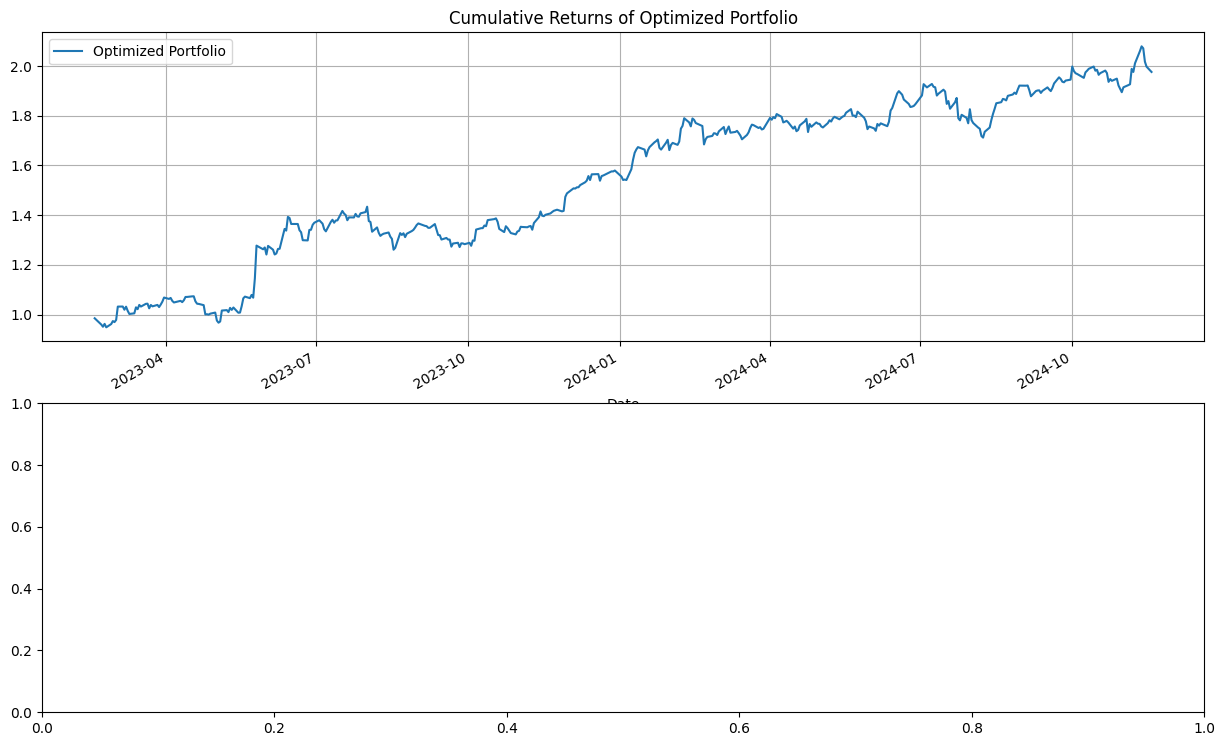

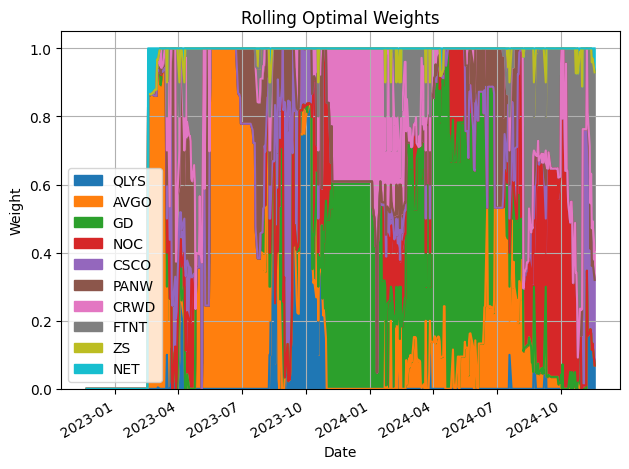


Optimized Portfolio Metrics:
                            Value
Annual Return            0.515134
Annual Volatility        0.231722
Sortino Ratio            3.821538
Calmar Ratio             4.270395
VaR (95%)               -0.017876
VaR (99%)               -0.032807
CVaR (95%)              -0.026669
CVaR (99%)              -0.039044
Skewness                 1.556961
Kurtosis                10.228518
Information Ratio        0.989712
Win Rate                 0.555556
Profit Ratio             1.116169
Max Consecutive Wins     8.000000
Max Consecutive Losses   7.000000
Average Rolling Beta     1.031939

Average Optimal Weights:
QLYS: 5.79%
AVGO: 21.39%
GD: 24.29%
NOC: 12.34%
CSCO: 6.53%
PANW: 9.22%
CRWD: 8.19%
FTNT: 10.92%
ZS: 0.55%
NET: 0.78%


In [11]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import yfinance as yf
from datetime import datetime, timedelta

def calculate_indicator(weights, returns):
    """
    Calculate Calmar ratio for portfolio in a single function
    
    Parameters:
    weights: numpy array of portfolio weights
    returns: pandas DataFrame of asset returns
    
    Returns:
    float: Negative Calmar ratio (for optimization purposes)
    """
    # Calculate portfolio returns
    portfolio_returns = np.sum(returns * weights, axis=1)
    
    # Calculate annualized return
    annual_return = np.mean(portfolio_returns) * 252
    
    # Calculate Maximum Drawdown
    cum_returns = (1 + portfolio_returns).cumprod()
    running_max = cum_returns.expanding().max()
    drawdown = cum_returns / running_max - 1
    mdd = abs(drawdown.min())
    
    # Add small epsilon to avoid division by zero
    epsilon = 1e-10
    
    # Calculate Calmar ratio
    calmar_ratio = annual_return / (mdd + epsilon)
    
    return -calmar_ratio  # Negative because we want to maximize

def optimize_portfolio(returns):
    """Optimize portfolio weights to maximize Sharpe ratio"""
    n_assets = returns.shape[1]
    
    # Constraints
    constraints = [
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}  # weights sum to 1
    ]
    
    # Bounds (0 to 1 for each weight: without short
    bounds = tuple((0, 1) for _ in range(n_assets))
    
    # Initial guess (equal weights)
    init_weights = np.array([1/n_assets] * n_assets)
    
    # Optimize
    result = minimize(calculate_indicator, 
                     init_weights,
                     args=(returns,),
                     method='SLSQP',
                     bounds = bounds, 
                     constraints=constraints)
    
    return result.x if result.success else init_weights

def rolling_optimization(price_data, window_size=60):
    """Perform rolling window optimization"""
    returns = price_data.pct_change()
    optimal_weights = pd.DataFrame(index=returns.index, columns=returns.columns)
    
    for i in range(window_size, len(returns)):
        # Get window of returns
        window_returns = returns.iloc[i-window_size:i]
        
        # Optimize for this window
        weights = optimize_portfolio(window_returns)
        
        # Store the weights
        optimal_weights.iloc[i] = weights
    
    # Forward fill the weights for any missing periods
    optimal_weights = optimal_weights.fillna(method='ffill')
    
    return optimal_weights

def calculate_optimized_portfolio_performance(price_data, optimal_weights):
    """Calculate portfolio performance using optimized weights"""
    returns = price_data.pct_change()
    portfolio_returns = pd.Series(index=returns.index)
    
    # Calculate portfolio returns using the optimized weights
    for i in range(len(returns)):
        if i >= len(optimal_weights) or optimal_weights.iloc[i].isnull().any():
            continue
        portfolio_returns.iloc[i] = np.sum(returns.iloc[i] * optimal_weights.iloc[i])
    
    return portfolio_returns

# Modified main function to include optimization
def main():
    # File portfolio tickers 
    tech_tickers = ['QLYS', 'AVGO', 'GD', 'NOC',
    'CSCO', 'PANW', 'CRWD', 'FTNT',
    'ZS', 'NET']
    
    # Get data
    price_data = get_stock_data(tech_tickers, start_date, end_date)
    
    # Perform rolling optimization
    optimal_weights = rolling_optimization(price_data, window_size=60)
    
    # Calculate optimized portfolio performance
    optimized_returns = calculate_optimized_portfolio_performance(price_data, optimal_weights)
    
    # Calculate cumulative returns
    cumulative_returns = (1 + optimized_returns).cumprod()
    
    # Calculate metrics for optimized portfolio
    metrics = calculate_enhanced_metrics(optimized_returns)
    
    # Plot results
    plt.figure(figsize=(15, 10))
    
    # Plot 1: Cumulative Returns
    plt.subplot(2, 1, 1)
    cumulative_returns.plot(label='Optimized Portfolio')
    plt.title('Cumulative Returns of Optimized Portfolio')
    plt.grid(True)
    plt.legend()
    
    # Plot 2: Rolling Weights
    plt.subplot(2, 1, 2)
    optimal_weights.plot.area(stacked=True)
    plt.title('Rolling Optimal Weights')
    plt.xlabel('Date')
    plt.ylabel('Weight')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Print metrics
    print("\nOptimized Portfolio Metrics:")
    metrics_df = pd.DataFrame(metrics, index=['Value']).T
    print(metrics_df)
    
    # Print average weights
    print("\nAverage Optimal Weights:")
    avg_weights = optimal_weights.mean()
    for ticker, weight in avg_weights.items():
        print(f"{ticker}: {weight:.2%}")
    
    return {
        'optimal_weights': optimal_weights,
        'portfolio_returns': optimized_returns,
        'cumulative_returns': cumulative_returns,
        'metrics': metrics
    }

if __name__ == "__main__":
    results = main()

### Summary : 
- The optimization produced a portfolio with:

    - Slightly lower returns (-4.16%)
    - Better risk metrics across all VaR and CVaR measures
    - Higher Calmar ratio and Sortino ratio
    - Much more positive skew but higher kurtosis
    - Significantly lower market exposure (beta)
    - Similar win rate and profit ratio

The optimization appears to have traded off a small amount of return for better risk-adjusted performance and lower market exposure. While the non-optimized portfolio had slightly higher returns, the optimized version shows better risk management characteristics, particularly in terms of downside protection (VaR, CVaR) and market exposure (beta).